## import the libraries 

In [1]:
import uproot3
import dask.dataframe as dd
import time
from dask import delayed
import numpy as np
import pandas as pd
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 200
from matplotlib import rcParams
rcParams.update({'figure.autolayout': True})
import seaborn as sns
import os

pd.pandas.set_option('display.max_columns',None)

/cvmfs/sft.cern.ch/lcg/views/LCG_102swan/x86_64-centos7-gcc11-opt/lib/python3.9/site-packages/uproot3/__init__.py:127: FutureWarning: Consider switching from 'uproot3' to 'uproot', since the new interface became the default in 2020.

    pip install -U uproot

In Python:

    >>> import uproot
    >>> with uproot.open(...) as file:
    ...

  warnings.warn(
/cvmfs/sft.cern.ch/lcg/views/LCG_102swan/x86_64-centos7-gcc11-opt/lib/python3.9/site-packages/awkward0/__init__.py:12: FutureWarning: Consider switching from 'awkward0' to 'awkward', since the new interface became the default in 2020.

    pip install -U awkward

In Python:

    >>> import awkward as ak
    >>> new_style_array = ak.from_awkward0(old_style_array)
    >>> old_style_array = ak.to_awkward0(new_style_array)

  warnings.warn(


## Check if jupyter notebook or script

In [2]:
def in_ipynb():
    try:
        cfg = get_ipython().config
        print(cfg)
        if 'jupyter' in cfg['IPKernelApp']['connection_file']:
            return True
        else:
            return False
    except NameError:
        return False

In [3]:
if in_ipynb():
    print("In IPython")
    TrainConfig="Configs/BinaryClassification_XGBoost_endcap"
    exec("import "+TrainConfig.replace("/", ".")+" as Conf")
else:
    TrainConfig=sys.argv[1]
    print("Importing settings from "+ TrainConfig.replace("/", "."))
    #exec("from "+TrainConfig+" import *")
    importConfig=TrainConfig.replace("/", ".")
    exec("import "+importConfig+" as Conf")

{'IPKernelApp': {'connection_file': '/scratch/rchudasa/.local/share/jupyter/runtime/kernel-4899e72a-2a67-45e5-ad18-df4fd46cc7b9.json'}, 'InteractiveShellApp': {'extensions': <LazyConfigValue value=['sparkmonitor.kernelextension', 'swankernelenv']>}}
In IPython


2022-09-15 15:13:19.156675: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /cvmfs/sft.cern.ch/lcg/releases/MCGenerators/thepeg/2.2.3-88592/x86_64-centos7-gcc11-opt/lib/ThePEG:/cvmfs/sft.cern.ch/lcg/releases/MCGenerators/herwig++/7.2.3-35f7a/x86_64-centos7-gcc11-opt/lib/Herwig:/cvmfs/sft.cern.ch/lcg/views/LCG_102swan/x86_64-centos7-gcc11-opt/lib/python3.9/site-packages/jaxlib/mlir/_mlir_libs:/cvmfs/sft.cern.ch/lcg/views/LCG_102swan/x86_64-centos7-gcc11-opt/lib/python3.9/site-packages/torch/lib:/cvmfs/sft.cern.ch/lcg/views/LCG_102swan/x86_64-centos7-gcc11-opt/lib/python3.9/site-packages/onnxruntime/capi/:/cvmfs/sft.cern.ch/lcg/views/LCG_102swan/x86_64-centos7-gcc11-opt/lib/python3.9/site-packages/tensorflow:/cvmfs/sft.cern.ch/lcg/views/LCG_102swan/x86_64-centos7-gcc11-opt/lib/python3.9/site-packages/tensorflow/contrib

In [4]:
import os
os.system("")
os.system("mkdir -p " + Conf.OutputDirName)

0

### Function to return pandas dataframe from root file 

In [5]:
def get_pandasDataFrame(process,cat,path,fileName,treeName,branches,selection):
    print(selection)
    eventsPhoton  = uproot3.open(path+fileName)[treeName]
    #pd_dataframe  = eventsPhoton.pandas.df(branches=branches)
    pd_dataframe  = eventsPhoton.pandas.df(branches=branches).query(selection)
    pd_dataframe['Process'] = process
    pd_dataframe['Category'] = cat

    
    print(pd_dataframe.shape)
    return pd_dataframe

### Append pandas dataframe to dask framework using delayed to reduce the computing time

In [6]:
dfs= []
start = time.time()
for process in Conf.processes:
    path = Conf.baseInputPath
    pr = process['process']
    cat = process['category']
    fileName  = process['fileName']
    treeName  = process['treeName']
    selection = process['selection']
    print(path,fileName,treeName)
    dfs.append(delayed(get_pandasDataFrame(pr,cat,path,fileName,treeName,branches=Conf.branches,selection=selection)))
end  = time.time()
print("Execution time is", end-start)


/eos/user/r/rchudasa/SWAN_projects/photonID-pp-Run2/makeInputTrees/workarea/ mc_signal_bsMMG_endcap.root genMatchedBMMGSCTree
(scEt>4) & (scEt<15) & abs(scEta)>1.566 & abs(scEta) < 2.4
(72371, 26)
/eos/user/r/rchudasa/SWAN_projects/photonID-pp-Run2/makeInputTrees/workarea/ mc_qcd20To30EmEnriched_endcap.root mergedPi0_SCTree
(scEt>4) & (scEt<15) & abs(scEta)>1.566 & abs(scEta) < 2.4
(123895, 26)
/eos/user/r/rchudasa/SWAN_projects/photonID-pp-Run2/makeInputTrees/workarea/ mc_bkg_flat_pi0_endcap.root mergedPi0_SCTree
(scEt>4) & (scEt<15) & abs(scEta)>1.566 & abs(scEta)<2.4
(17291, 26)
/eos/user/r/rchudasa/SWAN_projects/photonID-pp-Run2/makeInputTrees/workarea/ data_2018D_endcap.root dataAllSCTree
(scEt>4) & (scEt<15) & abs(scEta)>1.566 & abs(scEta) < 2.4
(382178, 26)
Execution time is 3.437965154647827


In [7]:
daskframe = dd.from_delayed(dfs)
final_df = daskframe.compute()
final_df.reset_index(inplace=True, drop=True)

In [8]:
final_df.head()

,scE,scEt,scEta,scPhi,scEtaWidth,scMinDrWithGsfElectornSC_,scFoundGsfMatch_,scR9,scSigmaIetaIeta,scSigmaIetaIphi,scEMaxRatio,scSwissCross,scE2x5_MaxRatio,scE2ndRatio,scPFPhoIso1,scPFPhoIso2,scPFPhoIso3,scPFPhoIso4,scPFPhoIso5,scPFChIso1,scPFChIso2,scPFChIso3,scPFChIso4,scPFChIso5,Process,Category
0,17.124434,5.111846,1.879032,-0.819066,0.025572,1.000000e+09,0.0,0.885800,0.017902,0.000222,0.775372,0.710296,1.000000,0.224628,3.462248,4.099676,4.324628,7.889235,7.889235,1.815070,3.897044,7.754038,9.133965,12.619382,bsMMG,0
1,24.669886,9.745676,1.580388,1.304956,0.003096,2.240261e+00,0.0,1.000000,0.016174,-0.000093,0.888417,0.874403,1.000000,0.088652,0.000000,0.000000,0.000000,0.000000,0.833241,0.506073,2.823912,5.028801,8.425012,9.865065,bsMMG,0
2,21.999235,6.611433,-1.871969,1.976124,0.010102,0.000000e+00,1.0,1.000000,0.020907,-0.000072,0.722597,0.616102,0.946634,0.147213,0.000000,0.000000,0.000000,0.000000,0.000000,0.459449,0.459449,2.801852,5.727080,9.649850,bsMMG,0
3,25.879095,8.798177,-1.741803,0.559429,0.013409,1.000000e+09,0.0,0.838818,0.036833,-0.000059,0.479300,0.119227,0.906453,0.333189,2.683528,2.683528,4.418558,4.606974,4.606974,7.305373,7.305373,9.594089,14.489732,17.313068,bsMMG,0
4,30.303923,11.885474,1.588221,-2.074802,0.006721,0.000000e+00,1.0,0.872347,0.023500,-0.000052,0.741974,0.692424,1.000000,0.123380,0.000000,2.284233,3.315942,3.678190,4.284877,0.000000,3.213417,5.203255,10.654004,12.805341,bsMMG,0


In [9]:
#final_df.tail()

In [10]:
final_df.shape

(595735, 26)

## Prepare the dataframe for reweighting and finding weights  

In [11]:
final_df['Process'].unique()

array(['bsMMG', 'QCD', 'Flat_pi0', 'Data'], dtype=object)

In [12]:
final_df['Class']=final_df['Process'].map({'bsMMG':'signal','Data':'bkg','QCD':'bkg',"Flat_pi0":'bkg'})
final_df["NewWt"]=1
final_df["xsecwt"]=1


In [13]:
final_df.head()

,scE,scEt,scEta,scPhi,scEtaWidth,scMinDrWithGsfElectornSC_,scFoundGsfMatch_,scR9,scSigmaIetaIeta,scSigmaIetaIphi,scEMaxRatio,scSwissCross,scE2x5_MaxRatio,scE2ndRatio,scPFPhoIso1,scPFPhoIso2,scPFPhoIso3,scPFPhoIso4,scPFPhoIso5,scPFChIso1,scPFChIso2,scPFChIso3,scPFChIso4,scPFChIso5,Process,Category,Class,NewWt,xsecwt
0,17.124434,5.111846,1.879032,-0.819066,0.025572,1.000000e+09,0.0,0.885800,0.017902,0.000222,0.775372,0.710296,1.000000,0.224628,3.462248,4.099676,4.324628,7.889235,7.889235,1.815070,3.897044,7.754038,9.133965,12.619382,bsMMG,0,signal,1,1
1,24.669886,9.745676,1.580388,1.304956,0.003096,2.240261e+00,0.0,1.000000,0.016174,-0.000093,0.888417,0.874403,1.000000,0.088652,0.000000,0.000000,0.000000,0.000000,0.833241,0.506073,2.823912,5.028801,8.425012,9.865065,bsMMG,0,signal,1,1
2,21.999235,6.611433,-1.871969,1.976124,0.010102,0.000000e+00,1.0,1.000000,0.020907,-0.000072,0.722597,0.616102,0.946634,0.147213,0.000000,0.000000,0.000000,0.000000,0.000000,0.459449,0.459449,2.801852,5.727080,9.649850,bsMMG,0,signal,1,1
3,25.879095,8.798177,-1.741803,0.559429,0.013409,1.000000e+09,0.0,0.838818,0.036833,-0.000059,0.479300,0.119227,0.906453,0.333189,2.683528,2.683528,4.418558,4.606974,4.606974,7.305373,7.305373,9.594089,14.489732,17.313068,bsMMG,0,signal,1,1
4,30.303923,11.885474,1.588221,-2.074802,0.006721,0.000000e+00,1.0,0.872347,0.023500,-0.000052,0.741974,0.692424,1.000000,0.123380,0.000000,2.284233,3.315942,3.678190,4.284877,0.000000,3.213417,5.203255,10.654004,12.805341,bsMMG,0,signal,1,1


In [14]:
Classes = ['signal','bkg']

## Divide the dataframe for training and testing
adapted from LPC Egamma ID tutorial

In [15]:
index = final_df.index
from sklearn.model_selection import train_test_split
TrainIndices=[]
TestIndices=[]
for myclass in Classes:
    condition = final_df["Class"] == myclass
    Indices = index[condition].values.tolist()
    myclassTrainIndices, myclassTestIndices = train_test_split(Indices, test_size=0.25, random_state=42, shuffle=True)
    TrainIndices=TrainIndices + myclassTrainIndices
    TestIndices=TestIndices + myclassTestIndices

final_df.loc[TrainIndices,'Dataset'] = "Train"
final_df.loc[TestIndices,'Dataset'] = "Test"

final_df.loc[TrainIndices,'TrainDataset'] = 1
final_df.loc[TestIndices,'TrainDataset'] = 0

In [16]:
final_df[(final_df['Dataset']=='Train') & (final_df['Class']=='bkg')].shape

(392523, 31)

In [17]:
final_df[(final_df['Dataset']=='Train') & (final_df['Class']=='signal')].shape

(54278, 31)

Text(0.5, 1.0, 'Number of samples')

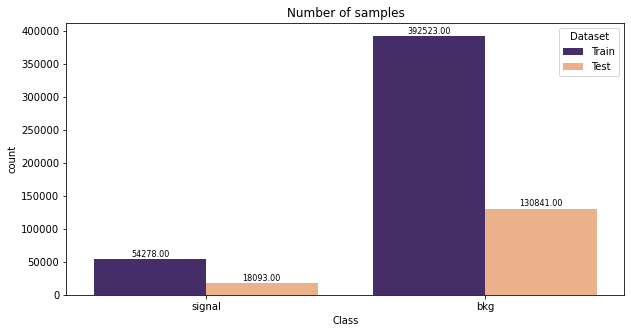

In [18]:
import seaborn as sns
import matplotlib.pyplot as plt
fig, axes = plt.subplots(1, 1, figsize=(10, 5))
kplot=sns.countplot(x="Class", data=final_df, ax=axes,hue='Dataset',palette=['#432371',"#FAAE7B","black"])

for p in kplot.patches:
    kplot.annotate(format(p.get_height(), '.2f'), (p.get_x() + p.get_width() / 2., p.get_height()), ha = 'center', va = 'center', xytext = (0, 5), textcoords = 'offset points',size=8)
axes.set_title("Number of samples")

In [19]:
def MyBins(lower,upper,step): return np.arange(lower,upper,step).tolist() 
def prGreen(prt): print("\033[92m {}\033[00m" .format(prt))


def MakeFeaturePlots(df_final,features,feature_bins,Set="Train",OutputDirName='Figures',cat='Category',label=[""],weight="NewWt",log=False):
    fig, axes = plt.subplots(1, len(features), figsize=(len(features)*5, 5))
    #fig, axes = plt.subplots(1, 1, figsize=(len(features)*5, 5))

    prGreen("Making "+Set+" dataset spectator plots")
    for m in range(len(features)):
        for i,group_df in df_final[df_final['Dataset'] == Set].groupby(cat):
            print(m, i)
            group_df[features[m]].hist(histtype='step', bins=feature_bins[m], alpha=1,label=label[i], ax=axes[m], density=False, ls='-', weights =group_df[weight]/group_df[weight].sum(),linewidth=2)
        axes[m].legend(loc='best')
        axes[m].set_xlabel(features[m])
        if log:
            axes[m].set_yscale("log")
            axes[m].set_ylim([0.0001,1])
        axes[m].set_title(features[m]+" ("+Set+" Dataset)")
        plt.savefig(OutputDirName+'/'+features[m]+Set+".png".format(m))




 Making Train dataset spectator plots
0 0
0 1
1 0
1 1


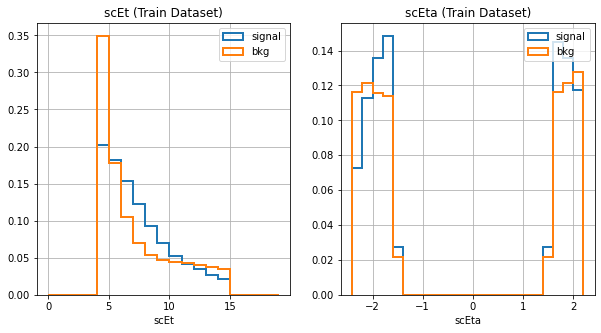

In [20]:
Variables=['scEt','scEta']
VarBins=[MyBins(0,20,1), MyBins(-2.4,2.4,0.2)]
MakeFeaturePlots(final_df,Variables,VarBins,Set="Train",OutputDirName=Conf.OutputDirName,label=Classes,log=False)

 Making Train dataset spectator plots
0 0
0 1
1 0
1 1
2 0
2 1
3 0
3 1


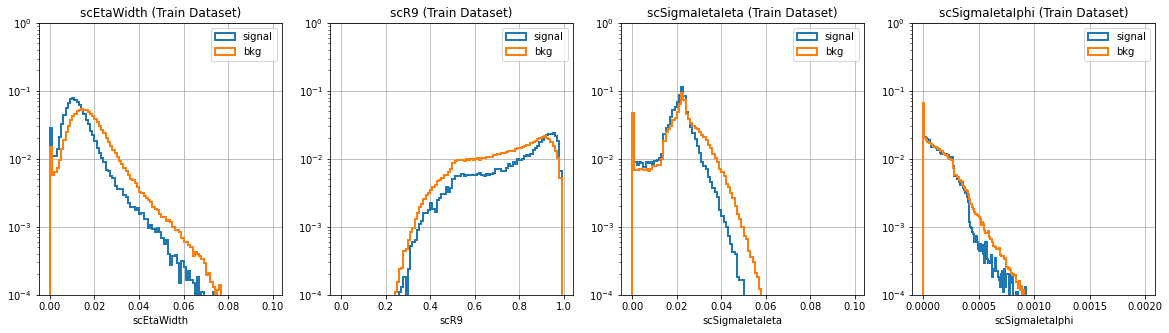

In [21]:
ShowerShape_widths=['scEtaWidth',
          'scR9',
          'scSigmaIetaIeta',
          'scSigmaIetaIphi']
VarBins=[MyBins(0,0.1,0.001), 
        MyBins(0,1,0.01), 
        MyBins(0,0.1,0.001),
        MyBins(0,0.002,0.00001)]
MakeFeaturePlots(final_df,ShowerShape_widths,VarBins,Set="Train",OutputDirName='figures_barrel',label=Classes,log=True)

 Making Train dataset spectator plots
0 0
0 1
1 0
1 1
2 0
2 1
3 0
3 1


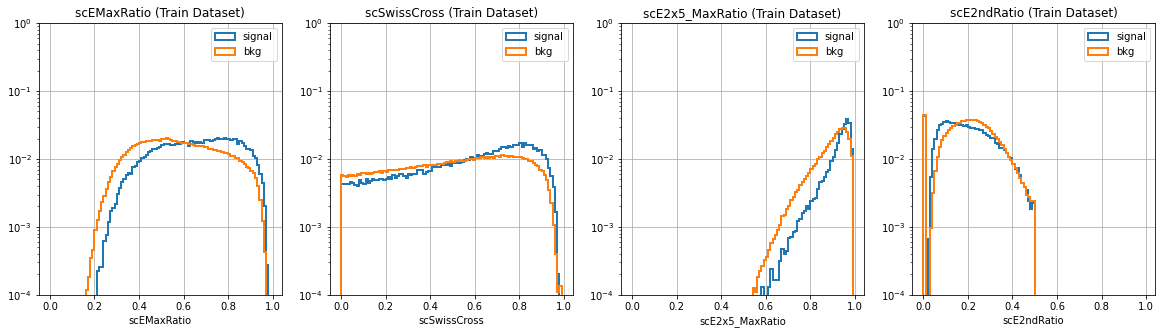

In [22]:
ShowerShape_Ratios=['scEMaxRatio',
          'scSwissCross',
          'scE2x5_MaxRatio',
          'scE2ndRatio']
VarBins=[MyBins(0,1,0.01)]*len(ShowerShape_Ratios)
MakeFeaturePlots(final_df,ShowerShape_Ratios,VarBins,Set="Train",OutputDirName='figures_barrel',label=Classes,log=True)

 Making Train dataset spectator plots
0 0
0 1
1 0
1 1
2 0
2 1


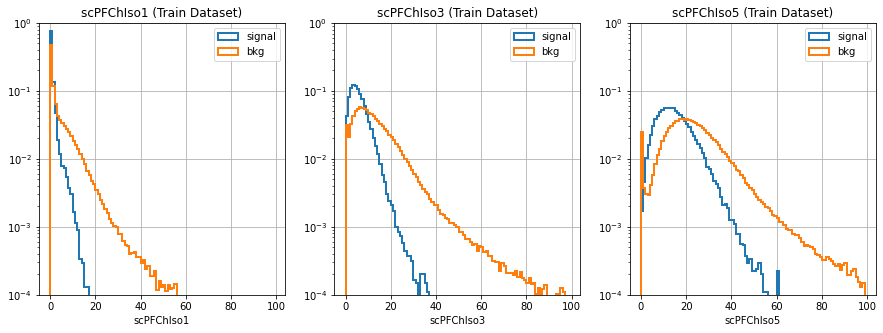

In [23]:
isolation_vars=['scPFChIso1','scPFChIso3','scPFChIso5']
VarBins=[MyBins(0,100,1)]*len(isolation_vars)
MakeFeaturePlots(final_df,isolation_vars,VarBins,Set="Train",OutputDirName='figures_barrel',label=Classes,log=True)

## Reweighting 

In [24]:
import Tools.ptetaRwt as ptetaRwt

In [25]:
final_df.loc[TrainIndices,"NewWt"]=ptetaRwt.df_pteta_rwt(final_df.loc[TrainIndices],"Class",
                                                   #ptw=[4,6,8,10,13,15],etaw=[-2.4,-2.0,-1.566,1.566,2.0,2.4],
                                                   ptw=Conf.ptbins,etaw=Conf.etabins,
                                                   pt='scEt',eta='scEta',
                                                   SumWeightCol='xsecwt',NewWeightCol="NewWt",
                                                   cand="signal",Classes=Classes)

final_df.loc[TestIndices,"NewWt"]=ptetaRwt.df_pteta_rwt(final_df.loc[TestIndices],"Class",
                                                   #ptw=[4,6,8,10,13,15],etaw=[-2.4,-2.0,-1.566,1.566,2.0,2.4],
                                                   #ptw=[4,6,8,10,13,15],etaw=[-1.4442,-1.1,-0.8,-0.5,0,0.5,0.8,1.1,1.4442],
                                                   ptw=Conf.ptbins,etaw=Conf.etabins,
                                                   pt='scEt',eta='scEta',
                                                   SumWeightCol='xsecwt',NewWeightCol="NewWt",
                                                   cand="signal",Classes=Classes)

Number of xsec events in bkg for pt 4 to 6 before  weighing = 44863
Number of xsec events in signal for pt 4 to 6 before  weighing = 4194
Number of xsec events in bkg for pt 6 to 8 before  weighing = 14929
Number of xsec events in signal for pt 6 to 8 before  weighing = 2583
Number of xsec events in bkg for pt 8 to 10 before  weighing = 10475
Number of xsec events in signal for pt 8 to 10 before  weighing = 1553
Number of xsec events in bkg for pt 10 to 13 before  weighing = 14518
Number of xsec events in signal for pt 10 to 13 before  weighing = 1277
Number of xsec events in bkg for pt 13 to 15 before  weighing = 8515
Number of xsec events in signal for pt 13 to 15 before  weighing = 471
Number of xsec events in bkg for pt 4 to 6 before  weighing = 55183
Number of xsec events in signal for pt 4 to 6 before  weighing = 6043
Number of xsec events in bkg for pt 6 to 8 before  weighing = 18758
Number of xsec events in signal for pt 6 to 8 before  weighing = 4960
Number of xsec events in b

In [26]:
final_df['NewWt'].unique()

array([1.        , 0.17301896, 0.14392991, 0.32756933, 0.05531415,
       0.15087422, 0.163277  , 0.05776682, 0.3150655 , 0.14825776,
       0.08795977, 0.08770891, 0.17310071, 0.22008309, 0.08715596,
       0.09236915, 0.1089862 , 0.04979109, 0.14726534, 0.26442051,
       0.08427081, 0.10950836, 0.2206945 , 0.09076145, 0.14636578,
       0.24901677, 0.30854606, 0.24979945, 0.24715472, 0.17406143,
       0.05096661, 0.16657768, 0.10578381, 0.09348461, 0.15720979,
       0.22734255, 0.18035395, 0.21626506, 0.3089907 , 0.10628889,
       0.09278215])

Text(0.5, 1.0, 'Number of samples')

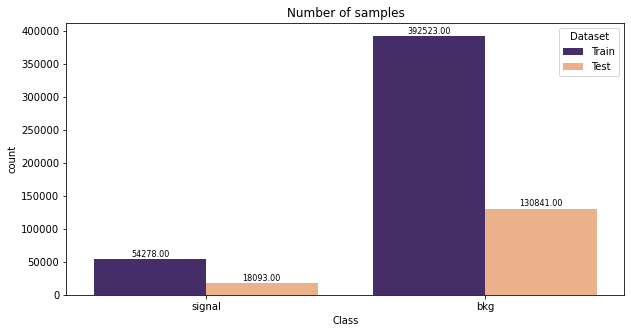

In [27]:
import seaborn as sns
import matplotlib.pyplot as plt
fig, axes = plt.subplots(1, 1, figsize=(10, 5))
kplot=sns.countplot(x="Class", data=final_df, ax=axes,hue='Dataset',palette=['#432371',"#FAAE7B","black"])

for p in kplot.patches:
    kplot.annotate(format(p.get_height(), '.2f'), (p.get_x() + p.get_width() / 2., p.get_height()), ha = 'center', va = 'center', xytext = (0, 5), textcoords = 'offset points',size=8)
axes.set_title("Number of samples")

 Making Train dataset spectator plots
0 0
0 1
1 0
1 1


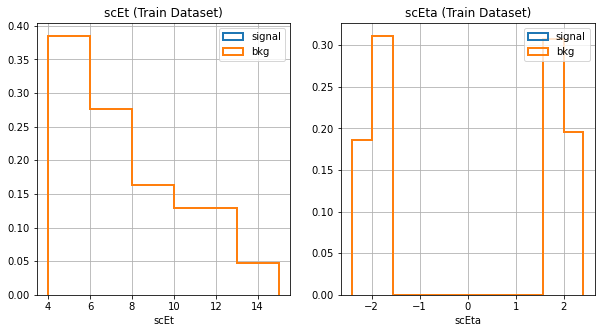

In [28]:
Variables=['scEt','scEta']
#VarBins=[[4,6,8,10,13,15], [-2.4,-2.0,-1.566,1.566,2.0,2.4]]
VarBins=[Conf.ptbins,Conf.etabins]
MakeFeaturePlots(final_df,Variables,VarBins,Set="Train",OutputDirName='figures_barrel',label=Classes,log=False)

## Define MVA parameters as a dictionary 

In [29]:
import pickle
import multiprocessing
import seaborn as sns

In [30]:
MVA = {"MVAtype":"XGB_1", #Keyword to identify MVA method.
     "Color":"green", #Plot color for MVA
     "Label":"XGB small list", # label can be anything (this is how you will identify them on plot legends)
     "features":['scEtaWidth','scR9','scSigmaIetaIeta','scSigmaIetaIphi','scEMaxRatio','scSwissCross','scE2x5_MaxRatio','scE2ndRatio','scPFChIso1','scPFChIso3','scPFChIso5'],
     "feature_bins":[MyBins(0,0.1,0.001), MyBins(0,1,0.01), MyBins(0,0.1,0.001),MyBins(0,0.002,0.00001),MyBins(0,1,0.01),MyBins(0,1,0.01),MyBins(0,1,0.01),MyBins(0,1,0.01), 
                    MyBins(0,100,1),MyBins(0,100,1),MyBins(0,100,1)], #same length as features #Binning used only for plotting features (should be in the same order as features), 
     'Scaler':"StandardScaler", #Scaling for features before passing to the model training
     'UseGPU':False, #If you have a GPU card, you can turn on this option (CUDA 10.0, Compute Capability 3.5 required)
     "XGBGridSearch":{'colsample_bytree': [0.5,1.0], 'gamma': [0.5], 'max_depth': [5,3], 'min_child_weight': [5], 'subsample': [0.8]}
      }

os.system("mkdir -p " + Conf.OutputDirName+"/"+MVA["MVAtype"])

0

In [31]:
def corre(df,Classes=[''],MVA={}):
    for C in Classes:
            for k in ["Train","Test"]:
                fig, axes = plt.subplots(1, 1, figsize=(len(MVA["features"]), len(MVA["features"])))
                cor = df.loc[(df['Dataset'] == k) & (df['Class'] == str(C))][MVA["features"]].corr()
                sns.heatmap(cor, annot=True, cmap=plt.cm.Reds,ax=axes,annot_kws={"size":len(MVA["features"])/4})
                axes.tick_params(axis='x', labelsize=len(MVA["features"]))
                axes.tick_params(axis='y', labelsize=len(MVA["features"]))
                
                fig.savefig(Conf.OutputDirName+"/"+MVA["MVAtype"]+"_"+C+"_CORRELATION_"+k+".png")
                fig.savefig(Conf.OutputDirName+"/"+MVA["MVAtype"]+"_"+C+"_CORRELATION_"+k+".pdf")

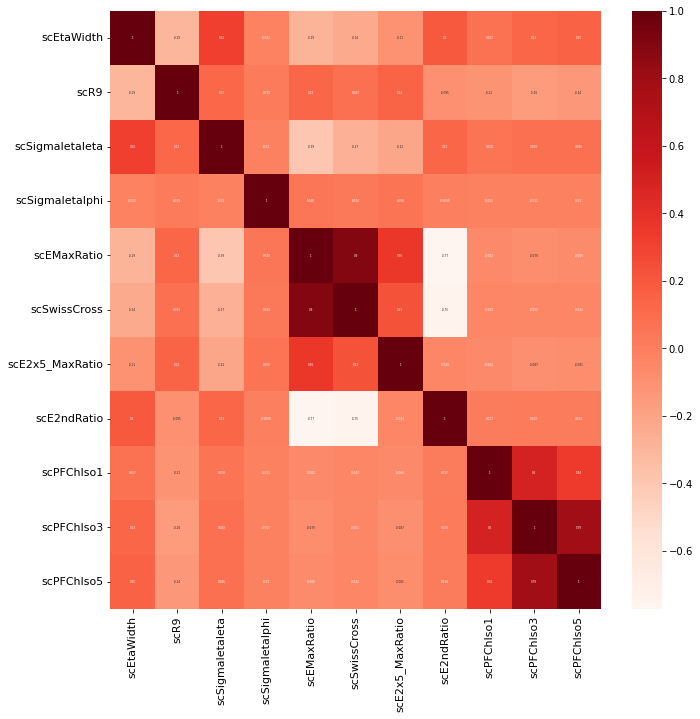

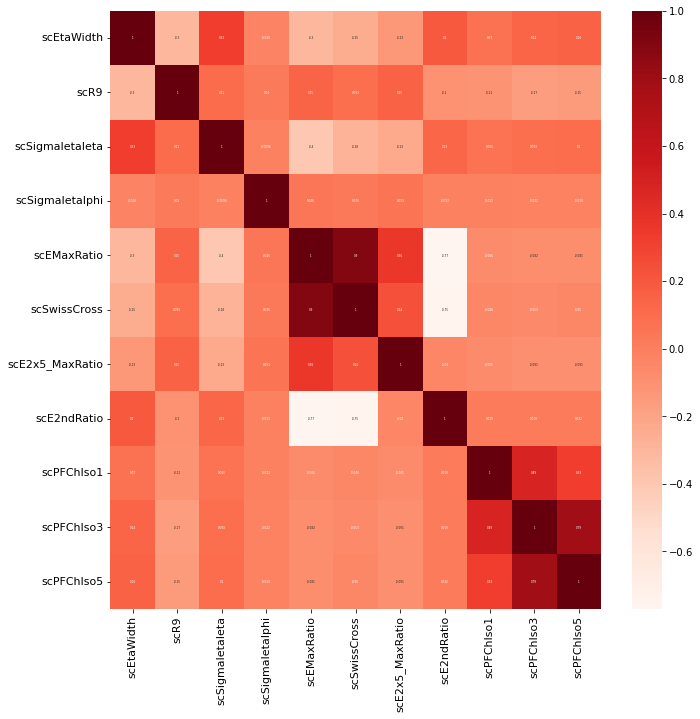

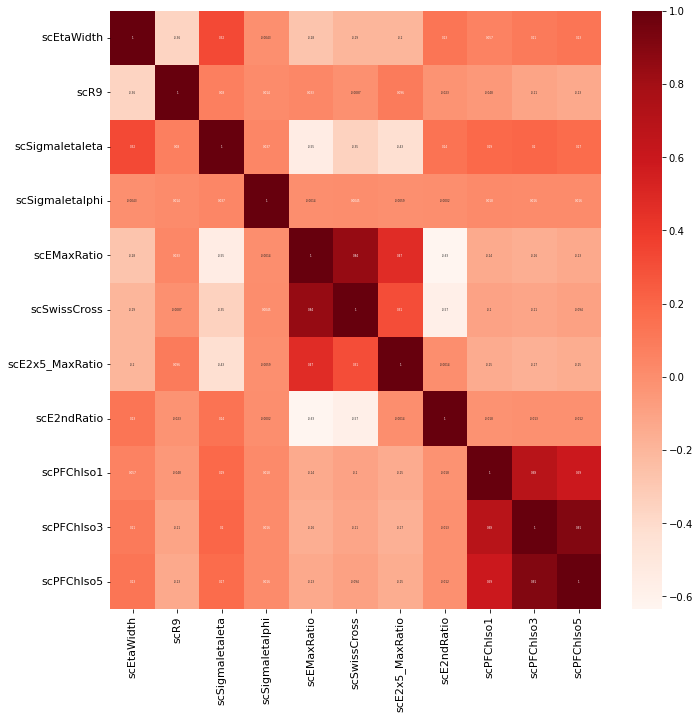

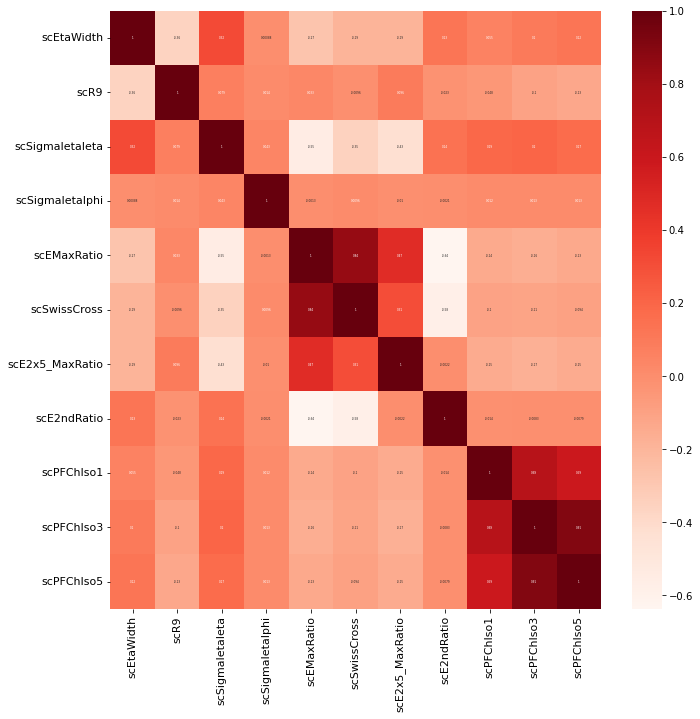

In [32]:
corre(final_df,Classes,MVA)

 Making Train dataset spectator plots
0 0
0 1
1 0
1 1
2 0
2 1
3 0
3 1
4 0
4 1
5 0
5 1
6 0
6 1
7 0
7 1
8 0
8 1
9 0
9 1
10 0
10 1


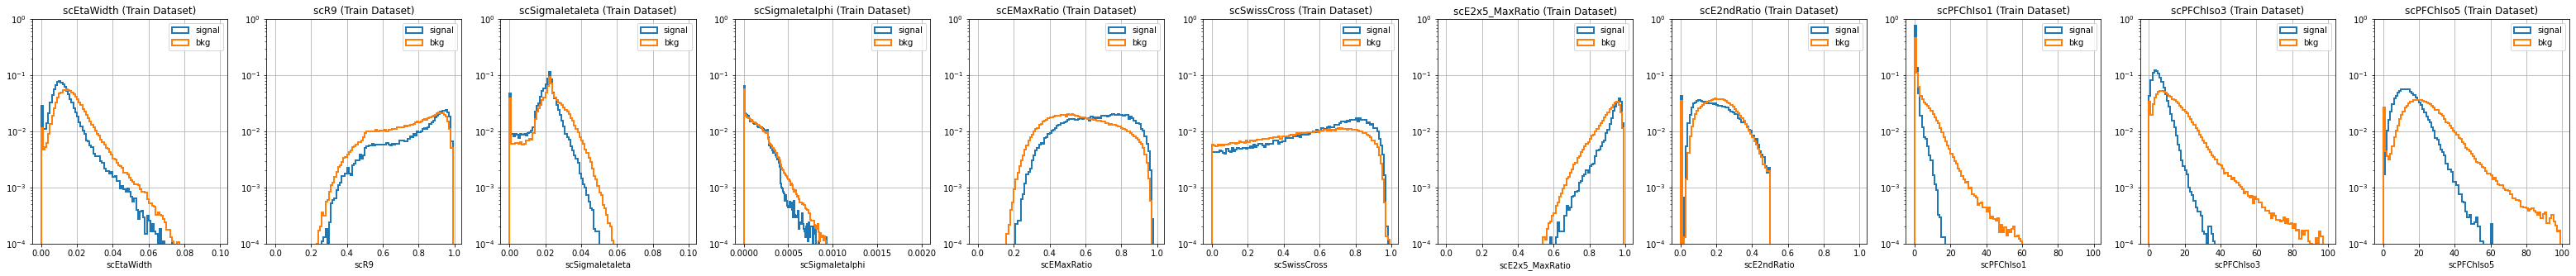

In [33]:
MakeFeaturePlots(final_df,MVA["features"],MVA["feature_bins"],Set="Train",OutputDirName='figures_barrel',label=Classes,log=True)

## Data preparation 

In [34]:
def PrepDataset(df_final,TrainIndices,TestIndices,features,cat,weight):
    X_train = df_final.loc[TrainIndices,features]
    Y_train = df_final.loc[TrainIndices,cat]
    Wt_train = df_final.loc[TrainIndices,weight]

    X_test = df_final.loc[TestIndices,features]
    Y_test = df_final.loc[TestIndices,cat]
    Wt_test = df_final.loc[TestIndices,weight]
    return np.asarray(X_train), np.asarray(Y_train), np.asarray(Wt_train), np.asarray(X_test), np.asarray(Y_test), np.asarray(Wt_test)

## XGBoost training

In [35]:
'''
def runXGBTraining(df_final,TrainIndices,TestIndices,MVA,Scaler,cat,weight="NewWt"):
    X_train, Y_train, Wt_train, X_test, Y_test, Wt_test = PrepDataset(df_final,TrainIndices,TestIndices,MVA["features"],cat,weight)
    exec("from sklearn.preprocessing import "+MVA["Scaler"])
    exec("sc = "+MVA["Scaler"]+"()")
    #scale the training data input features so that it is between 0 and 1
    X_train = Scaler.fit_transform(X_train) 
    X_test = Scaler.transform(X_test)
    
    import xgboost as xgb
    from sklearn.model_selection import cross_val_score, GridSearchCV
    eval_s = [(X_train, Y_train),(X_test,Y_test)]
    if "UseGPU" in MVA and MVA["UseGPU"]:
        xgb_model = xgb.XGBClassifier(objective="binary:logistic", tree_method= 'gpu_hist',random_state=42)
    else:
        xgb_model = xgb.XGBClassifier(objective="binary:logistic",random_state=42)
    cv = GridSearchCV(xgb_model, MVA["XGBGridSearch"],scoring='neg_log_loss',cv=3,verbose=1)
    search=cv.fit(X_train, Y_train, sample_weight=Wt_train,verbose=0,eval_set=eval_s)
    prGreen("Expected neg log loss of XGB model = "+str((np.round(np.average(search.best_score_),3))*100)+'%')
    prGreen("XGB Best Parameters")
    prGreen(str(search.best_params_))
    fig, ax = plt.subplots()
    ax.barh(MVA["features"],cv.best_estimator_.feature_importances_)
    ax.set_xlabel("Xgboost Feature Importance")
    
    return X_train, Y_train, Wt_train, X_test, Y_test, Wt_test,cv, search
'''

'\ndef runXGBTraining(df_final,TrainIndices,TestIndices,MVA,Scaler,cat,weight="NewWt"):\n    X_train, Y_train, Wt_train, X_test, Y_test, Wt_test = PrepDataset(df_final,TrainIndices,TestIndices,MVA["features"],cat,weight)\n    exec("from sklearn.preprocessing import "+MVA["Scaler"])\n    exec("sc = "+MVA["Scaler"]+"()")\n    #scale the training data input features so that it is between 0 and 1\n    X_train = Scaler.fit_transform(X_train) \n    X_test = Scaler.transform(X_test)\n    \n    import xgboost as xgb\n    from sklearn.model_selection import cross_val_score, GridSearchCV\n    eval_s = [(X_train, Y_train),(X_test,Y_test)]\n    if "UseGPU" in MVA and MVA["UseGPU"]:\n        xgb_model = xgb.XGBClassifier(objective="binary:logistic", tree_method= \'gpu_hist\',random_state=42)\n    else:\n        xgb_model = xgb.XGBClassifier(objective="binary:logistic",random_state=42)\n    cv = GridSearchCV(xgb_model, MVA["XGBGridSearch"],scoring=\'neg_log_loss\',cv=3,verbose=1)\n    search=cv.fit(

## Run the training

Fitting 3 folds for each of 4 candidates, totalling 12 fits
 Expected neg log loss of XGB model = -51.5%
 XGB Best Parameters
 {'colsample_bytree': 1.0, 'gamma': 0.5, 'max_depth': 5, 'min_child_weight': 5, 'subsample': 0.8}
Execution time is 604.0067594051361


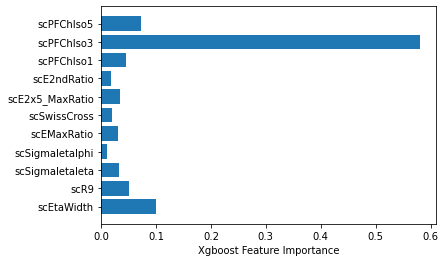

In [36]:
start = time.time()

exec("from sklearn.preprocessing import "+MVA["Scaler"])
exec("sc = "+MVA["Scaler"]+"()")

X_train, Y_train, Wt_train, X_test, Y_test, Wt_test = PrepDataset(final_df,TrainIndices,TestIndices,MVA["features"],cat='Category',weight="NewWt")
exec("from sklearn.preprocessing import "+MVA["Scaler"])
exec("sc = "+MVA["Scaler"]+"()")
#scale the training data input features so that it is between 0 and 1
X_train = sc.fit_transform(X_train) 
X_test = sc.transform(X_test)
    
import xgboost as xgb
from sklearn.model_selection import cross_val_score, GridSearchCV
eval_s = [(X_train, Y_train),(X_test,Y_test)]

#if "UseGPU" in MVA and MVA["UseGPU"]:
 #   xgb_model = xgb.XGBClassifier(objective="binary:logistic", tree_method= 'gpu_hist',random_state=42)
#else:
xgb_model = xgb.XGBClassifier(objective="binary:logistic",random_state=42)

cv = GridSearchCV(xgb_model, MVA["XGBGridSearch"],scoring='neg_log_loss',cv=3,verbose=1)
search=cv.fit(X_train, Y_train, sample_weight=Wt_train,verbose=0,eval_set=eval_s)
prGreen("Expected neg log loss of XGB model = "+str((np.round(np.average(search.best_score_),3))*100)+'%')
prGreen("XGB Best Parameters")
prGreen(str(search.best_params_))
fig, ax = plt.subplots()
ax.barh(MVA["features"],cv.best_estimator_.feature_importances_)
ax.set_xlabel("Xgboost Feature Importance")

#X_train, Y_train, Wt_train, X_test, Y_test, Wt_test, cv, search=runXGBTraining(final_df,TrainIndices,TestIndices,MVA,sc,cat='Category',weight="NewWt")

end = time.time()
print("Execution time is", end-start)

In [37]:
#from xgboost import plot_tree
#plot_tree(booster=search,trees=1)
#plt.show()

## Diagnostic error plot 

Text(0.5, 1.0, 'XGB small list XGBoost Error')

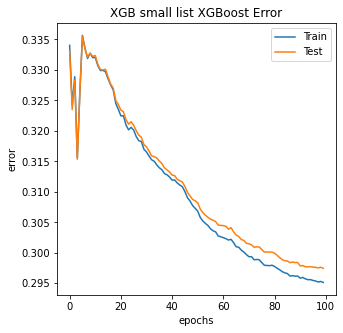

In [38]:
results = cv.best_estimator_.evals_result()
epochs = len(results['validation_0']['error'])
x_axis = range(0, epochs)
fig, ax = plt.subplots(figsize=(5,5))
        
ax.plot(x_axis, results['validation_0']['error'], label='Train')
ax.plot(x_axis, results['validation_1']['error'], label='Test')
ax.legend()
ax.set_ylabel('error')
ax.set_xlabel('epochs')
ax.set_title(MVA["Label"]+' XGBoost Error')

In [39]:
from tensorflow.keras.utils import to_categorical
y_test_pred=cv.predict_proba(X_test)
y_train_pred=cv.predict_proba(X_train)

Y_train = to_categorical(Y_train, num_classes=2)
Y_test = to_categorical(Y_test, num_classes=2)

In [40]:
final_df.loc[TrainIndices,MVA["MVAtype"]+"_pred"]=cv.predict_proba(X_train)[:,0]
final_df.loc[TestIndices,MVA["MVAtype"]+"_pred"]=cv.predict_proba(X_test)[:,0]

In [41]:
plotwt_train=np.asarray(final_df.loc[TrainIndices,'xsecwt'])
plotwt_test=np.asarray(final_df.loc[TestIndices,'xsecwt'])

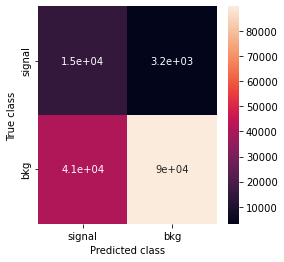

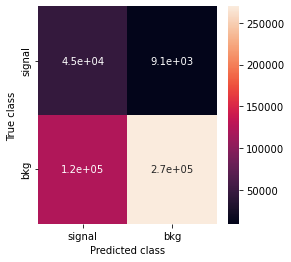

In [42]:
import pandas as pd

from sklearn.metrics import confusion_matrix
fig, axes = plt.subplots(1, 1, figsize=(len(Classes)*2, len(Classes)*2))
cm = confusion_matrix(Y_test.argmax(axis=1), y_test_pred.argmax(axis=1))
cm_df = pd.DataFrame(cm,index = Classes, columns = Classes)
sns.heatmap(cm_df, annot=True,ax=axes)
axes.set_yticklabels(axes.get_yticklabels(), va='center')
axes.set_xticklabels(axes.get_yticklabels(), ha='center')
axes.set_ylabel("True class")
axes.set_xlabel("Predicted class")

fig, axes = plt.subplots(1, 1, figsize=(len(Classes)*2, len(Classes)*2))
cm = confusion_matrix(Y_train.argmax(axis=1), y_train_pred.argmax(axis=1))
cm_df = pd.DataFrame(cm,index = Classes,columns = Classes)
sns.heatmap(cm_df, annot=True,ax=axes)
axes.set_yticklabels(axes.get_yticklabels(), va='center')
axes.set_xticklabels(axes.get_yticklabels(), ha='center')
axes.set_ylabel("True class")
axes.set_xlabel("Predicted class")
fig.savefig(Conf.OutputDirName+"/"+MVA["MVAtype"]+"/"+MVA["MVAtype"]+"_"+"CM_Training.png") 

In [43]:
ClassColors =['#377eb8', '#ff7f00']

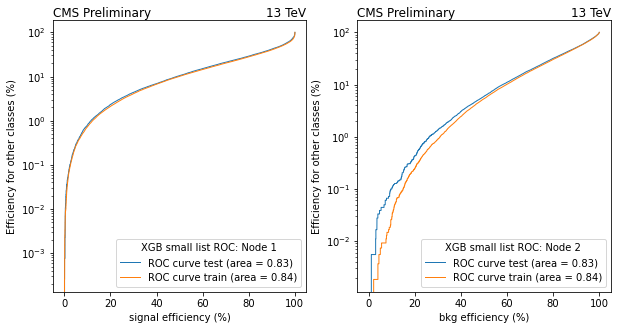

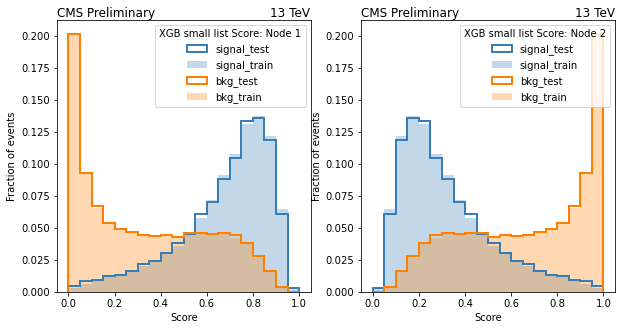

In [44]:
from sklearn.metrics import roc_curve, auc

n_classes=len(Classes)
fig, axes = plt.subplots(1, n_classes, figsize=(n_classes*5, 5))
figMVA, axesMVA = plt.subplots(1, n_classes, figsize=(n_classes*5, 5))    
for i in range(n_classes):
    axMVA=axesMVA[i]
    ax=axes[i]
    for k in range(n_classes):
        axMVA.hist(y_test_pred[:, i][Y_test[:, k]==1],bins=np.linspace(0, 1, 21),label=Classes[k]+'_test',
                   weights=plotwt_test[Y_test[:, k]==1]/np.sum(plotwt_test[Y_test[:, k]==1]),
                   histtype='step',linewidth=2,color=ClassColors[k])
        axMVA.hist(y_train_pred[:, i][Y_train[:, k]==1],bins=np.linspace(0, 1, 21),label=Classes[k]+'_train',
                   weights=plotwt_train[Y_train[:, k]==1]/np.sum(plotwt_train[Y_train[:, k]==1]),
                   histtype='stepfilled',alpha=0.3,linewidth=2,color=ClassColors[k])
        
    axMVA.set_xlabel('Score',fontsize=10)
        
    axMVA.set_ylabel('Fraction of events',fontsize=10)
    axMVA.legend(title=MVA["Label"]+' Score: Node '+str(i+1), loc="best",fontsize=10)
    axMVA.text(0, 1, "CMS Preliminary", horizontalalignment = 'left', verticalalignment = 'bottom', transform=axMVA.transAxes, fontsize = 12)#, fontweight = 'bold')
        
    axMVA.text(1, 1, "13 TeV", horizontalalignment = 'right', verticalalignment = 'bottom', transform = axMVA.transAxes, fontsize = 12)
    #axMVA.set_yscale('log')
            
    fpr, tpr, th = roc_curve(Y_test[:, i], y_test_pred[:, i],sample_weight=plotwt_test)
    fpr_tr, tpr_tr, th_tr = roc_curve(Y_train[:, i], y_train_pred[:, i],sample_weight=plotwt_train)
    mask = tpr > 0.0
    fpr, tpr = fpr[mask], tpr[mask]

    mask = tpr_tr > 0.0
    fpr_tr, tpr_tr = fpr_tr[mask], tpr_tr[mask]

    roc_auc = auc(fpr, tpr)
    roc_auc_tr = auc(fpr_tr, tpr_tr)
            
    ax.plot(tpr*100, fpr*100, label='ROC curve test (area = %0.2f)' % roc_auc,linewidth=1)
    ax.plot(tpr_tr*100, fpr_tr*100, label='ROC curve train (area = %0.2f)' % roc_auc_tr,linewidth=1)
    ax.text(0, 1, "CMS Preliminary", horizontalalignment = 'left', verticalalignment = 'bottom', transform=ax.transAxes, fontsize = 12)#, fontweight = 'bold')
    ax.text(1, 1, "13 TeV", horizontalalignment = 'right', verticalalignment = 'bottom', transform = ax.transAxes, fontsize = 12)
    ax.set_yscale("log")
    ax.set_xlabel(Classes[i]+' efficiency (%)',fontsize=10)
    ax.set_ylabel('Efficiency for other classes (%)',fontsize=10)
    ax.legend(title=MVA["Label"]+' ROC: Node '+str(i+1),loc="best",fontsize=10)

## Advanced exercise 

In [45]:
import math
from uncertainties import ufloat
from uncertainties.umath import *

In [46]:
def eff(group_df,var,cat,catvalue):
    signalpass=len(group_df.query('('+var+' == 1) & ('+cat+' == '+str(catvalue)+')'))
    signalpass=ufloat(signalpass,math.sqrt(signalpass))
    signaltotal=len(group_df.query('('+cat+' == '+str(catvalue)+')'))
    signaltoal=ufloat(signaltotal,math.sqrt(signaltotal))
    if signaltotal>0:
        signaleff=(100*signalpass)/(signaltotal)
        return [signaleff.n, signaleff.s]
    else:
        print("Some bins have zero signal: assigning zero eff")
        return [0, 0]

def EffTrend(cat='',var='',groupbyvar='',ptbins=[],label='',title='',plotname='',df=pd.DataFrame(),plot_dir='',Classes=[''],Colors=['']):
    figMVAComp, axesComp = plt.subplots(1,1, figsize=(4, 4))
    ax=axesComp
    fulllist=[[] for i in range(len(Classes))]
    fullliste=[[[] for i in range(2)] for i in range(len(Classes))]
    #ptbinsmy=ptbins[:-1]
    ptbinsmy=[(ptbins[m+1]+ptbins[m])/2 for m in range(len(ptbins)-1)]
    if groupbyvar=='ele_pt_bin':
        ptbinsmy[len(ptbinsmy)-1]=ptbins[len(ptbins)-2]*1.2
    #ptbinsmy.append(ptbins[len(ptbins)-1]*1.2)
    xefulllist=[(ptbins[m+1]-ptbins[m])/2 for m in range(len(ptbins)-1)]
    if groupbyvar=='ele_pt_bin':
        xefulllist[len(ptbinsmy)-1]=ptbins[len(ptbins)-2]*0.2
    for i,group_df in df.groupby(groupbyvar):
        for k in range(len(Classes)):
            val=eff(group_df,var,cat,k)[0]
            vale=eff(group_df,var,cat,k)[1]
            fulllist[k].append(val)
            fullliste[k][0].append(vale)
            if val+vale<100:
                fullliste[k][1].append(vale)
            else:
                fullliste[k][1].append(100-val)
                
        
    for m in range(len(Classes)):
        if len(Classes)>2:
            if m==0 or m==1:
                marker='S'
            else:
                marker='B'
        if len(Classes)<3:
            if m==1:
                marker='S'
            else:
                marker='B'
        ax.errorbar(ptbinsmy,fulllist[m],xerr=xefulllist,yerr=fullliste[m],markersize=6,markeredgecolor='black',label=Classes[m],color=Colors[m],fmt = '.')
    ax.set_ylim(0,130)
    if groupbyvar=='ele_pt_bin':
        #ax.set_yscale('log')
        ax.set_xlim(ptbins[0],ptbins[len(ptbins)-2]*1.4)
    #if groupbyvar=='ele_eta_bin':
        #ax.set_xlim(ptbins[0]*1.2,ptbins[len(ptbins)-1])
    ax.set_xlabel(label)
    ax.set_ylabel("Efficiency (%)")
    ax.set_title(title)
    ax.grid(True)
    #ax.legend(loc='best',ncol=2,bbox_to_anchor=(0., 1.1, 1., 0.2),fontsize=8)
    ax.legend(loc='best',ncol=2,fontsize=10)
    figMVAComp.savefig(plot_dir+plotname+".pdf")
    figMVAComp.savefig(plot_dir+plotname+".png")

## Efficiency studies at 80% and 90% working points

In [47]:
SigEffWPsi=["80%", "90%"]
MVAs=[MVA]
#ptbins = [4,4.5,5,5.5,6,6.5,7,7.5,8,8.5,9,9.5,10,12,15]
#etabins = [-2.4,-2.2,-2.0,-1.8,-1.566,1.566,1.8,2.0,2.2,2.4]
#etabins = [-1.4442,-1.1,-0.8,-0.5,0,0.5,0.8,1.1,1.4442]
ptbins = Conf.ptbins
etabins = Conf.etabins
ptwtvar='scEt'
etawtvar='scEta'

In [48]:
cat='Category'

Some bins have zero signal: assigning zero eff
Some bins have zero signal: assigning zero eff
Some bins have zero signal: assigning zero eff
Some bins have zero signal: assigning zero eff
Some bins have zero signal: assigning zero eff
Some bins have zero signal: assigning zero eff
Some bins have zero signal: assigning zero eff
Some bins have zero signal: assigning zero eff
Some bins have zero signal: assigning zero eff
Some bins have zero signal: assigning zero eff
Some bins have zero signal: assigning zero eff
Some bins have zero signal: assigning zero eff
Some bins have zero signal: assigning zero eff
Some bins have zero signal: assigning zero eff
Some bins have zero signal: assigning zero eff
Some bins have zero signal: assigning zero eff


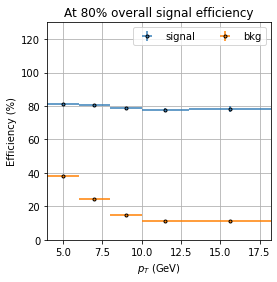

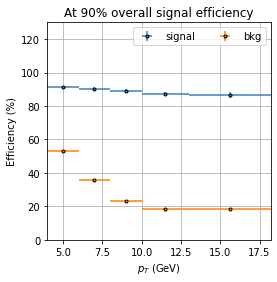

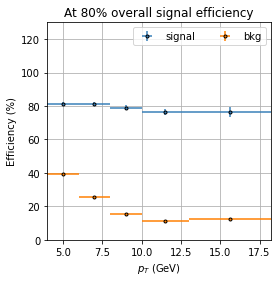

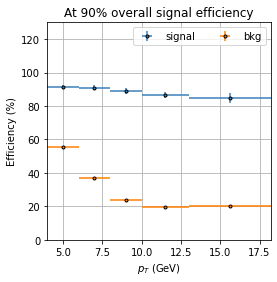

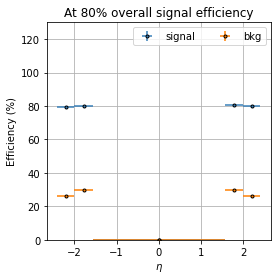

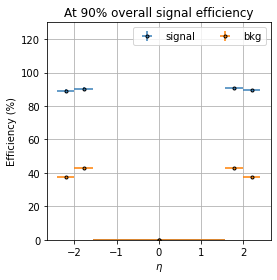

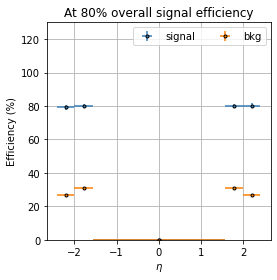

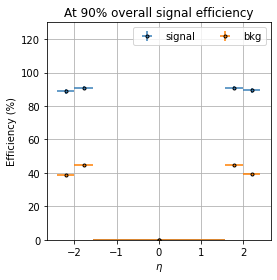

In [49]:
if len(SigEffWPsi)>0:
    PredMVAs=[]
    for MVA in MVAs:
        PredMVAs.append(MVA["MVAtype"]+'_pred')
    SigEffWPs=SigEffWPsi[:]
    for i,SigEffWPi in enumerate(SigEffWPs):
        SigEffWPs[i]=1-(int(SigEffWPi.replace('%', ''))/100)
    

    for MVA in MVAs:

        final_df["ele_pt_bin"] = pd.cut(final_df[ptwtvar], bins=ptbins, labels=list(range(len(ptbins)-1)))
        final_df["ele_eta_bin"] = pd.cut(final_df[etawtvar], bins=etabins, labels=list(range(len(etabins)-1)))

        EB_train=final_df.loc[TrainIndices]
        EB_test=final_df.loc[TestIndices]
        
        if len(Classes) > 2:
            
            mydftrain=EB_train.query(cat+"==1 | "+cat+"==0")[[MVA["MVAtype"]+"_pred"]].quantile(SigEffWPs)
            mydftest=EB_test.query(cat+"==1 | "+cat+"==0")[[MVA["MVAtype"]+"_pred"]].quantile(SigEffWPs)
            
            #figMVA, axesMVA = plt.subplots(1, n_classes, figsize=(5, 5))
            #plot_mva(EB_train, MVA["MVAtype"]+"_pred", 100, logscale=False, ax=axMVA, title="Combined Score", ls='dashed', alpha=0.5, sample='Train',cat="Class",Wt="Wt",Classes=Classes,Colors=ClassColors)
            
        if len(Classes) < 3:
            
            mydftrain=EB_train.query(cat+"==0")[[MVA["MVAtype"]+"_pred"]].quantile(SigEffWPs)
            mydftest=EB_test.query(cat+"==0")[[MVA["MVAtype"]+"_pred"]].quantile(SigEffWPs)
            
        EB_train.loc[EB_train[MVA["MVAtype"]+"_pred"] > mydftrain.iat[0,0], MVA["MVAtype"]+"_predpass"] = 1
        EB_train.loc[EB_train[MVA["MVAtype"]+"_pred"] < mydftrain.iat[0,0], MVA["MVAtype"]+"_predpass"] = 0

        EB_train.loc[EB_train[MVA["MVAtype"]+"_pred"] > mydftrain.iat[1,0], MVA["MVAtype"]+"_predpass1"] = 1
        EB_train.loc[EB_train[MVA["MVAtype"]+"_pred"] < mydftrain.iat[1,0], MVA["MVAtype"]+"_predpass1"] = 0

        EB_test.loc[EB_test[MVA["MVAtype"]+"_pred"] > mydftest.iat[0,0], MVA["MVAtype"]+"_predpass"] = 1
        EB_test.loc[EB_test[MVA["MVAtype"]+"_pred"] < mydftest.iat[0,0], MVA["MVAtype"]+"_predpass"] = 0

        EB_test.loc[EB_test[MVA["MVAtype"]+"_pred"] > mydftest.iat[1,0], MVA["MVAtype"]+"_predpass1"] = 1
        EB_test.loc[EB_test[MVA["MVAtype"]+"_pred"] < mydftest.iat[1,0], MVA["MVAtype"]+"_predpass1"] = 0

        variables=['ele_pt_bin','ele_eta_bin']
        bins=[ptbins,etabins]
        xaxislabels=['$p_T$ (GeV)','$\eta$']
        #Wps=OverlayWP

        for variable,xaxislabel,binn in zip(variables,xaxislabels,bins):
            EffTrend(cat=cat,var=MVA["MVAtype"]+"_predpass",groupbyvar=variable,ptbins=binn,label=xaxislabel,title=f"At {SigEffWPsi[0]} overall signal efficiency",plotname="New_MultiClass_ID_Val_"+str(SigEffWPs[0])+"_"+variable,df=EB_train,plot_dir=Conf.OutputDirName+"/"+MVA["MVAtype"]+"/Train_",Classes=Classes,Colors=ClassColors)
            EffTrend(cat=cat,var=MVA["MVAtype"]+"_predpass1",groupbyvar=variable,ptbins=binn,label=xaxislabel,title=f"At {SigEffWPsi[1]} overall signal efficiency",plotname="New_MultiClass_ID_Val_"+str(SigEffWPs[1])+"_"+variable,df=EB_train,plot_dir=Conf.OutputDirName+"/"+MVA["MVAtype"]+"/Train_",Classes=Classes,Colors=ClassColors)
            #for Wp in Wps:
             #   EffTrend(cat=cat,var=Wp,groupbyvar=variable,ptbins=binn, label=xaxislabel,title='CMSSW_ID_'+Wp,plotname="CMSSW_ID_"+Wp+"_"+variable,df=EB_train,plot_dir=OutputDirName+"/"+MVA["MVAtype"]+"/Train_",Classes=Classes,Colors=ClassColors)


            EffTrend(cat=cat,var=MVA["MVAtype"]+"_predpass",groupbyvar=variable,ptbins=binn,label=xaxislabel,title=f"At {SigEffWPsi[0]} overall signal efficiency",plotname="New_MultiClass_ID_Val_"+str(SigEffWPs[0])+"_"+variable,df=EB_test,plot_dir=Conf.OutputDirName+"/"+MVA["MVAtype"]+"/Test_",Classes=Classes,Colors=ClassColors)
            EffTrend(cat=cat,var=MVA["MVAtype"]+"_predpass1",groupbyvar=variable,ptbins=binn,label=xaxislabel,title=f"At {SigEffWPsi[1]} overall signal efficiency",plotname="New_MultiClass_ID_Val_"+str(SigEffWPs[1])+"_"+variable,df=EB_test,plot_dir=Conf.OutputDirName+"/"+MVA["MVAtype"]+"/Test_",Classes=Classes,Colors=ClassColors)
            #for Wp in Wps:
             #   EffTrend(cat=cat,var=Wp,groupbyvar=variable,ptbins=binn, label=xaxislabel,title='CMSSW_ID_'+Wp,plotname="CMSSW_ID_"+Wp+"_"+variable,df=EB_test,plot_dir=OutputDirName+"/"+MVA["MVAtype"]+"/Test_",Classes=Classes,Colors=ClassColors)